# Tests for Portfolio VaR Functions

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px

# Import functions
import PortfolioVaR as pv
import InteractivePlots

### Asset Normal/ Undiversified VaR

**NOTE**: figure out later if backtesting here makes sense, it should be possible.

**NOTE 2**: since we already have the parametric VaR, a Portfolio-Normal VaR function is redundant.

In [18]:
# Set parameters
confidence_level = 0.99
holding_period = 1

In [19]:
# Define a small time series of positions (3 assets over 5 days)
position_data = pd.DataFrame({
    "Asset_A": [98, 102, 100, 100, 108, 100],
    "Asset_B": [167, 198, 154, 145, 206, 210],
    "Asset_C": [345, 303, 306, 287, 312, 310],
    "Asset D": [123, 145, 167, 189, 312, 345],
    "Asset E": [-325, -300, -316, -287, -318, -330],
    "Asset F": [-1123, -1145, -1167, -1189, -1312, -1345],
    "Asset G": [1, 1, 6, 8, 2, 5],
}, index=pd.date_range("2023-01-01", periods=6))

In [20]:
# Compute Diversified VaR
var_series = pv.var_asset_normal(
    position_data=position_data,
    confidence_level=confidence_level,
    holding_period=holding_period,
    undiversified=False
)

# Compute Undiversified VaR
uvar_series = pv.var_asset_normal(
    position_data=position_data,
    confidence_level=confidence_level,
    holding_period=holding_period,
    undiversified=True
)

# Compute Diversification Benefit
div_benefit = uvar_series - var_series

# Combine in a DataFrame
result = pd.DataFrame({
    "Diversified_VaR": var_series,
    "Undiversified_VaR": uvar_series,
    "Diversification_Benefit": div_benefit
})

# Print result
print(result)


            Diversified_VaR  Undiversified_VaR  Diversification_Benefit
2023-01-02       106.525569         105.507647                -1.017921
2023-01-03        68.892608         113.613251                44.720642
2023-01-04        65.873941         131.222201                65.348259
2023-01-05       171.776206         188.769391                16.993185
2023-01-06       174.296471         217.721435                43.424964


In [21]:
# One-row static input
static_position = pd.DataFrame([[1_000_000, 2_000_000, 3_000_000]])

var = pv.var_asset_normal(static_position, confidence_level=0.99)
# -> Warning will be shown, and function returns None

/Users/aledo/Documents/GitHub/VaR/Functions/PortfolioVaR.py:71: UserWarning:

You must provide a time series of positions (at least 2 rows).



### Marginal VaR

In [22]:
# Call the marginal_var function
marginal_df = pv.marginal_var(
    position_data=position_data,
    confidence_level=confidence_level,
    holding_period=holding_period
)

# Print the result
print(marginal_df)

             Asset_A   Asset_B   Asset_C   Asset D   Asset E   Asset F  \
2023-01-02  0.117902  0.542146  0.020016  0.409075  0.008377  0.062081   
2023-01-03  0.130859  0.508726  0.029976  0.436928  0.019375  0.064086   
2023-01-04  0.132751  0.487079  0.054221  0.470918  0.049400  0.069218   
2023-01-05  0.121541  0.539824  0.066968  0.487994  0.058705  0.075526   
2023-01-06  0.122272  0.531056  0.075916  0.500361  0.069694  0.077374   

             Asset G  
2023-01-02 -4.629851  
2023-01-03 -3.961028  
2023-01-04 -3.264373  
2023-01-05 -3.972026  
2023-01-06 -3.708922  


### Incremental, Component and Relative Component VaR

In [23]:
# Test Component VaR
component_df = pv.component_var(position_data, confidence_level, holding_period)
print("Component VaR:")
print(component_df)

# Test Relative Component VaR
relative_df = pv.relative_component_var(position_data, confidence_level, holding_period)
print("\nRelative Component VaR:")
print(relative_df)

# Test Incremental VaR (e.g., add 100 to Asset_B)
change_vector = [0, 100, 0, 0, 0, 0, 0]
ivar_series = pv.incremental_var(position_data, change_vector, confidence_level, holding_period)
print("\nIncremental VaR (100 increase in Asset_B):")
print(ivar_series)

Component VaR:
              Asset_A     Asset_B    Asset_C     Asset D    Asset E  \
2023-01-02  12.026038  107.344869   6.064997   59.315894  -2.513137   
2023-01-03  13.085946   78.343758   9.172692   72.966970  -6.122621   
2023-01-04  13.275079   70.626439  15.561383   89.003570 -14.177785   
2023-01-05  13.126427  111.203813  20.894119  152.253973 -18.668174   
2023-01-06  12.227194  111.521752  23.533846  172.624524 -22.998862   

               Asset F    Asset G  
2023-01-02  -71.083242  -4.629851  
2023-01-03  -74.787966 -23.766170  
2023-01-04  -82.299763 -26.114981  
2023-01-05  -99.089900  -7.944052  
2023-01-06 -104.067374 -18.544610  

Relative Component VaR:
             Asset_A   Asset_B   Asset_C   Asset D   Asset E   Asset F  \
2023-01-02  0.112893  1.007691  0.056935  0.556823 -0.023592 -0.667288   
2023-01-03  0.189947  1.137187  0.133145  1.059141 -0.088872 -1.085573   
2023-01-04  0.201522  1.072145  0.236230  1.351120 -0.215226 -1.249352   
2023-01-05  0.076416 

### Final Check

In [24]:
# 1. Get total VaR from your main function
var_series = pv.var_asset_normal(position_data, confidence_level)

# 2. Sum of Component VaR per day
component_df = pv.component_var(position_data, confidence_level)
component_sum = component_df.sum(axis=1)

# 3. Sum of Relative Component VaR per day
relative_df = pv.relative_component_var(position_data, confidence_level)
relative_sum = relative_df.sum(axis=1)

# 4. Build comparison table
check_df = pd.DataFrame({
    "Portfolio_VaR": var_series,
    "Sum_Component_VaR": component_sum,
    "Diff": var_series - component_sum,
    "Sum_Relative_CVaR": relative_sum
})

print(check_df)


            Portfolio_VaR  Sum_Component_VaR          Diff  Sum_Relative_CVaR
2023-01-02     106.525569         106.525569  0.000000e+00                1.0
2023-01-03      68.892608          68.892608  5.684342e-14                1.0
2023-01-04      65.873941          65.873941  0.000000e+00                1.0
2023-01-05     171.776206         171.776206 -2.842171e-14                1.0
2023-01-06     174.296471         174.296471  0.000000e+00                1.0


### Visualizations

In [25]:
InteractivePlots.interactive_plot_var_series(var_series, uvar_series)

In [26]:
InteractivePlots.interactive_plot_risk_contribution_bar(component_df)

In [27]:
InteractivePlots.interactive_plot_risk_contribution_lines(component_df)

In [28]:
InteractivePlots.interactive_plot_correlation_matrix(position_data)

### Try Caller (with static plots)


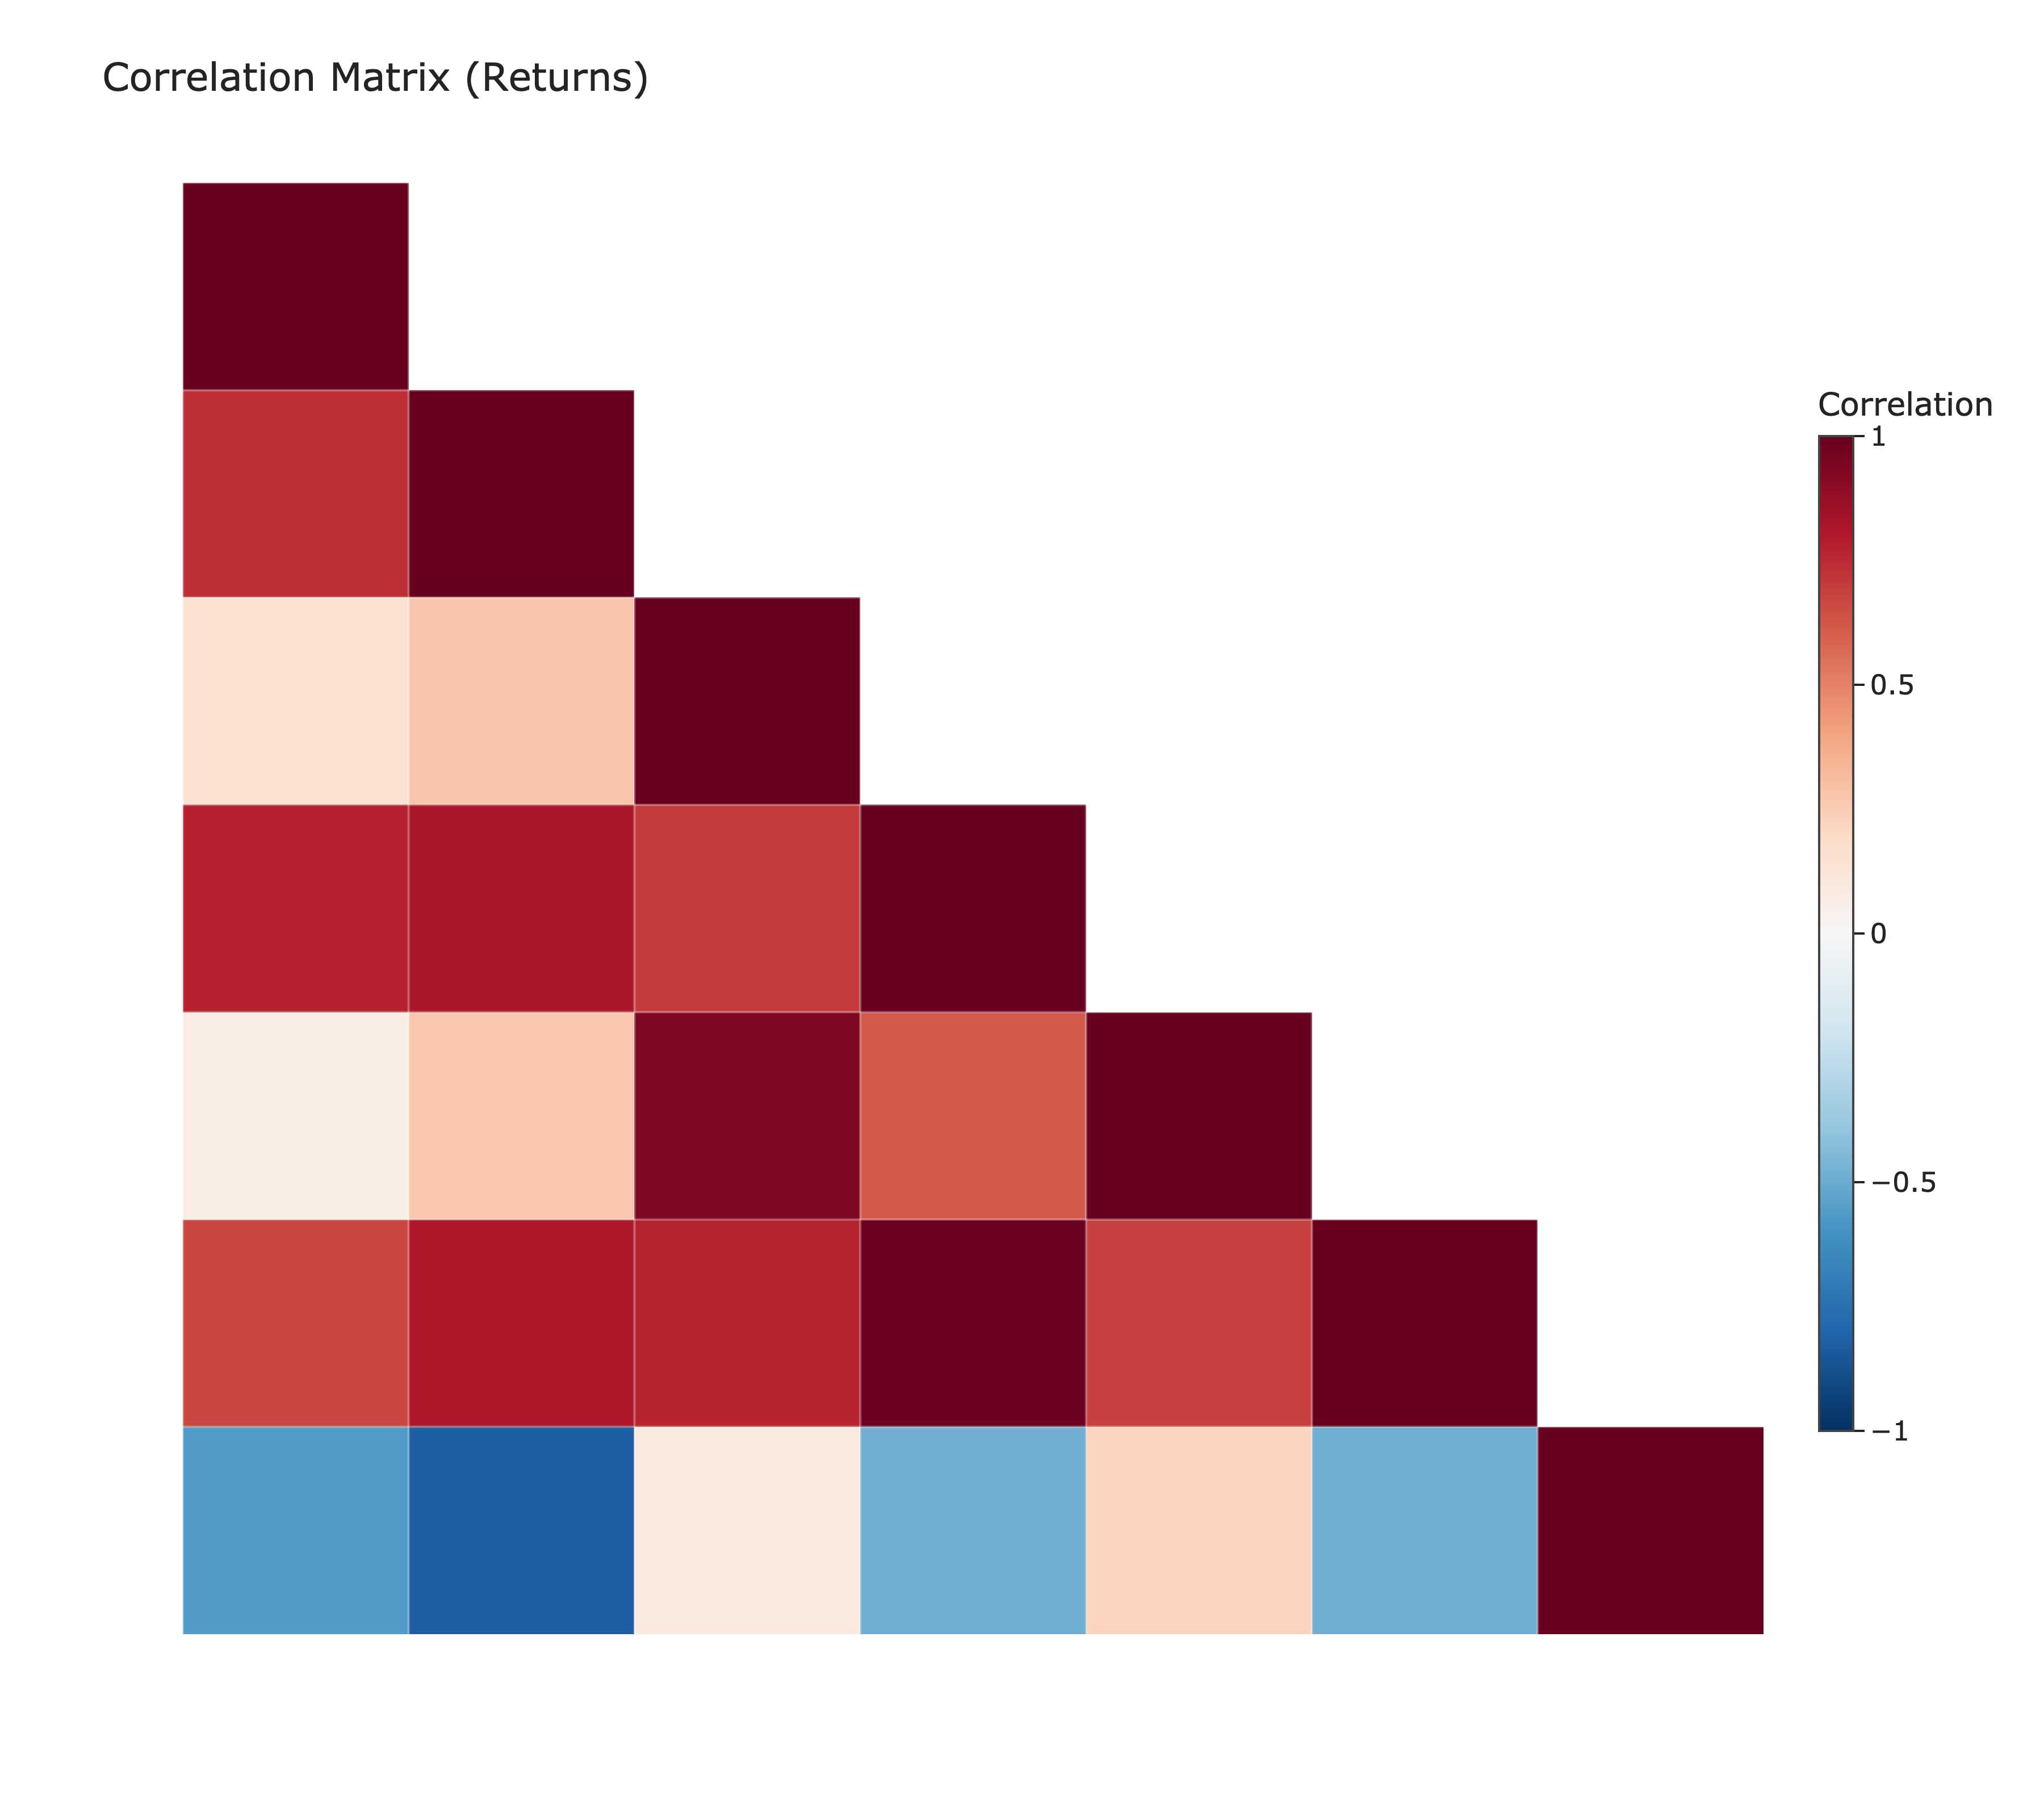

In [29]:
InteractivePlots.plot_caller(
    plot_type="correlation_matrix",
    interactive=False,
    position_data=position_data,
)



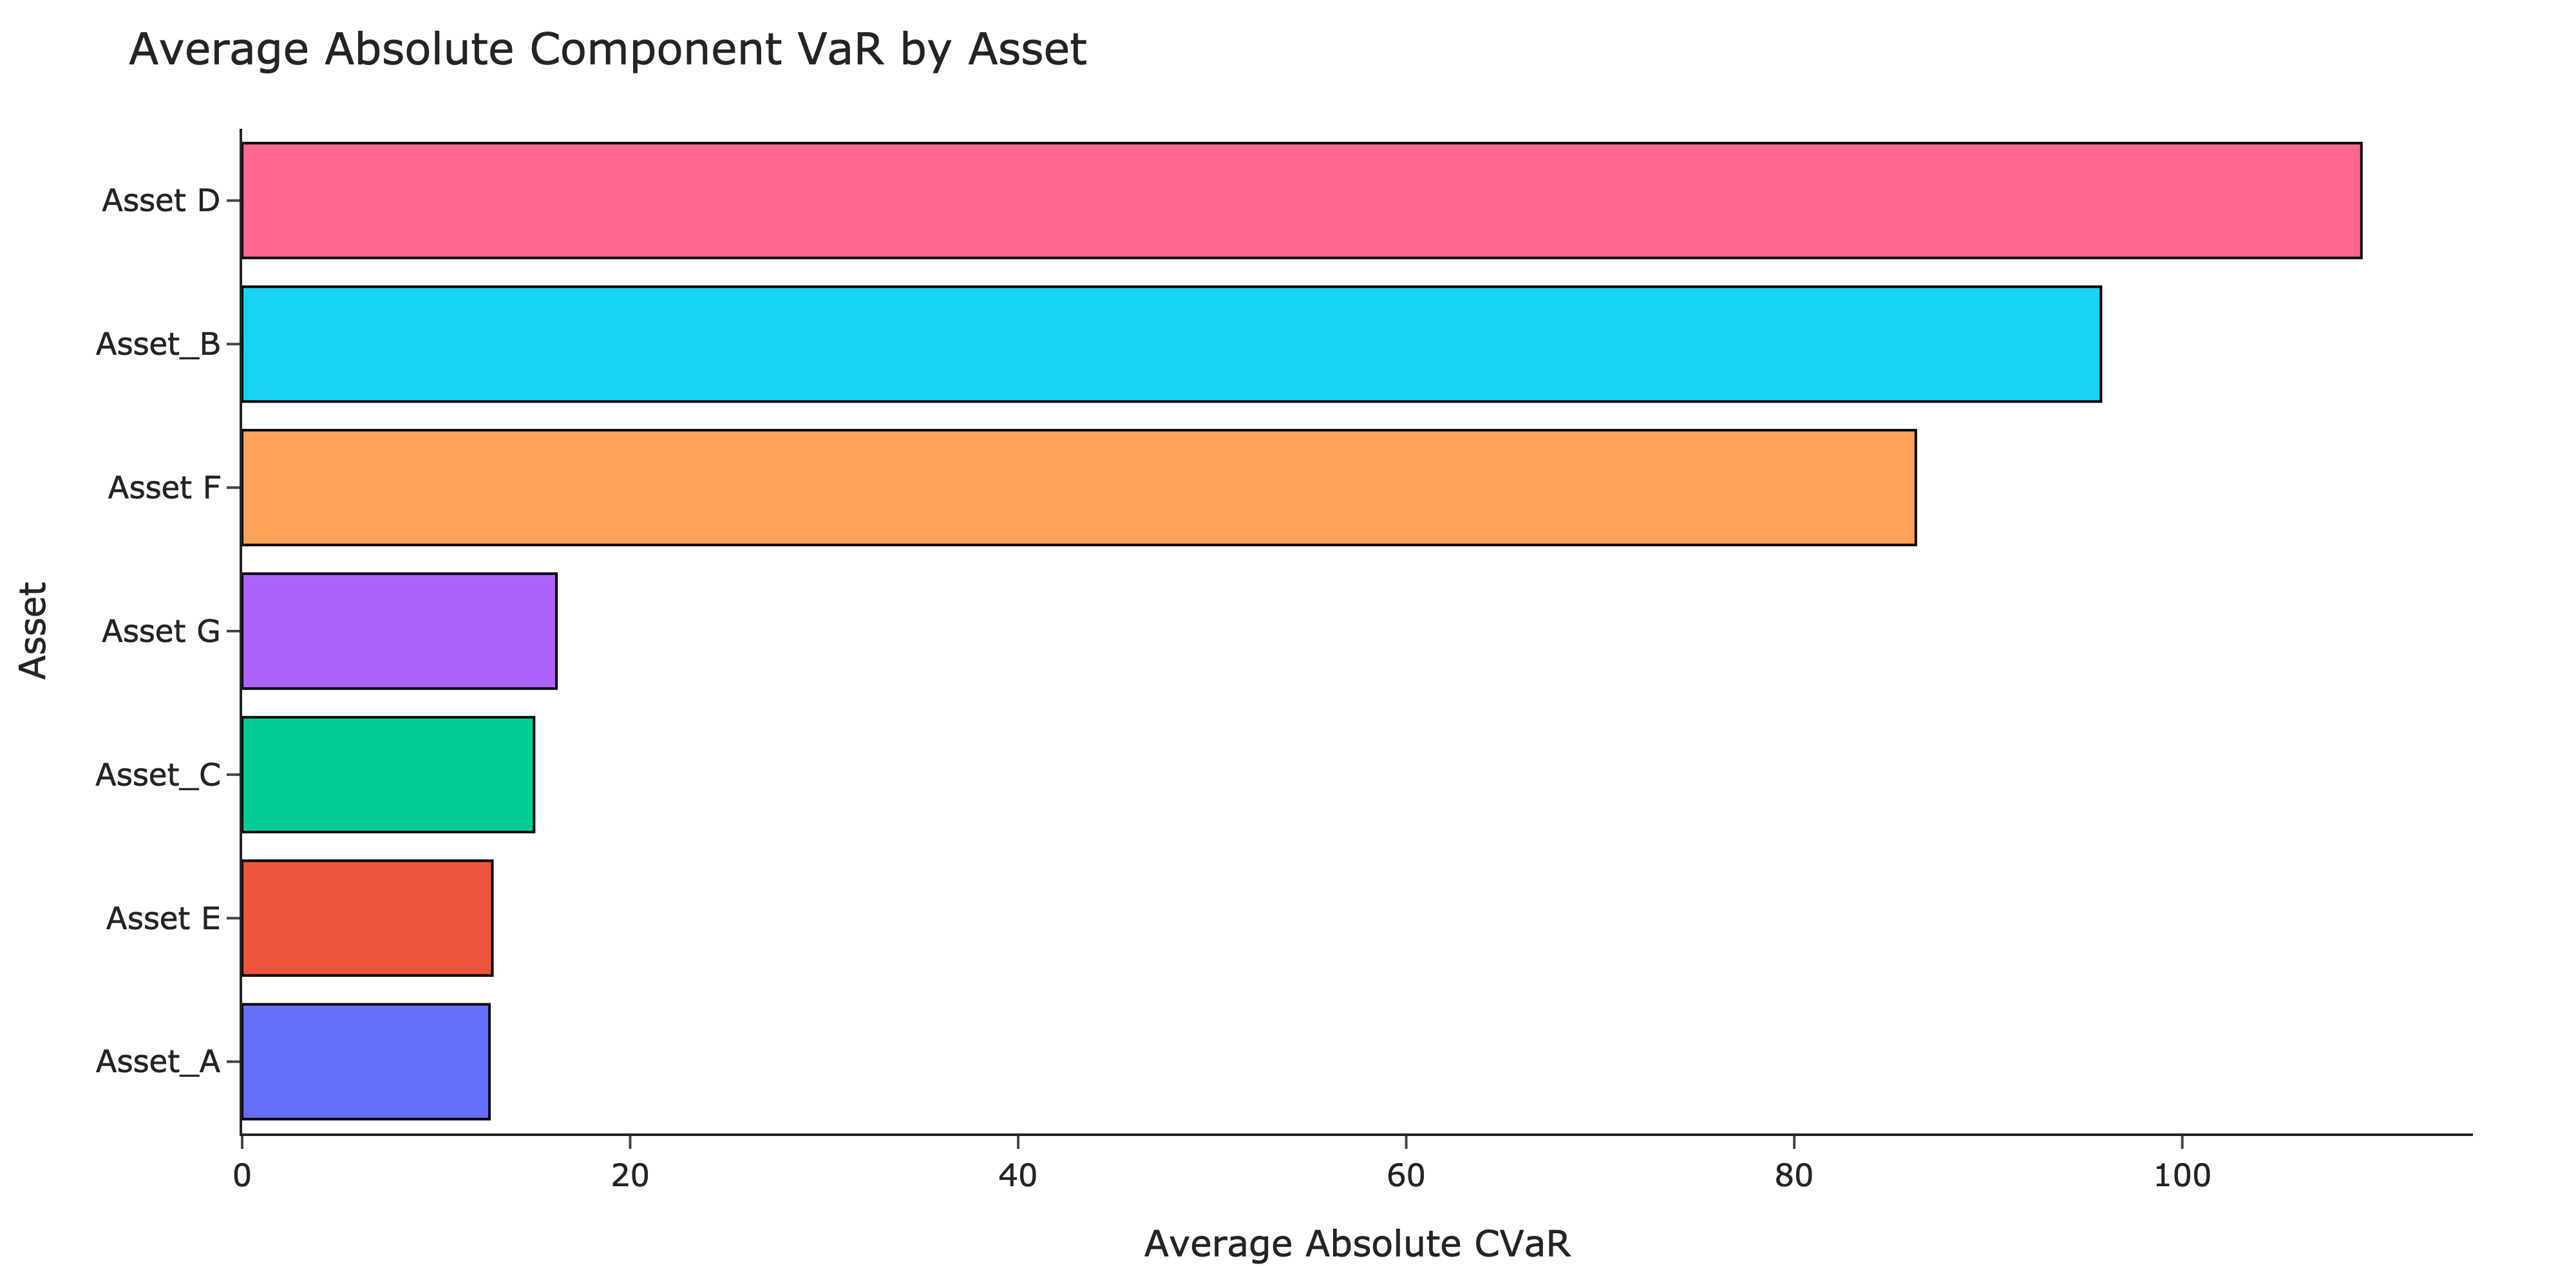

In [30]:
InteractivePlots.plot_caller(
    plot_type="component_var_bar",
    interactive=False,
    component_df=component_df
)


---
### Appendix

- **Asset-Normal VaR (AN VaR)**  
  $$
  \text{VaR}_t = z_\alpha \cdot \sqrt{x_t^\top \Sigma x_t} \cdot \sqrt{h}
  $$

- **Undiversified VaR (UVaR)**  
  $$
  \text{UVaR}_t = z_\alpha \cdot \sum_{i=1}^N \sigma_i x_{i,t} \cdot \sqrt{h}
  $$

- **Marginal VaR**  
  $$
  \Delta \text{VaR}_{i,t} = \text{VaR}_t \cdot \frac{(\Sigma x_t)_i}{x_t^\top \Sigma x_t}
  $$

- **Component VaR**  
  $$
  \text{CVaR}_{i,t} = x_{i,t} \cdot \Delta \text{VaR}_{i,t}
  $$

- **Relative Component VaR**  
  $$
  \text{RCVaR}_{i,t} = \frac{\text{CVaR}_{i,t}}{\text{VaR}_t}
  $$

- **Incremental VaR**  
  $$
  \text{IVaR}_t = \Delta \text{VaR}_t^\top \cdot a
  $$

---

### Function Dependencies

```text
var_asset_normal()
 └── marginal_var()
      ├── component_var()
      │     └── relative_component_var()
      └── incremental_var()
```

---

### Notes
- All risk measures are in **monetary terms**.
- Covariance is based on returns inferred from time series of holdings.
- Inputs: matrix of monetary holdings, confidence level $z_\alpha$, and horizon $h$.